In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_absolute_error


In [2]:
df_train = pd.read_csv("steel.csv")

#training label
Y = df_train["tensile_strength"]

#training features
X = df_train[["normalising_temperature",
              "tempering_temperature",
              "percent_silicon",
              "percent_chromium",
              "percent_copper",
              "percent_nickel",
              "percent_sulphur",
              "percent_carbon",
              "percent_manganese"]]
#preprocess by normalizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Default model (no preprocessing):
MAE: 41.456
R² for each fold: [np.float64(0.7915), np.float64(0.6115), np.float64(0.5303), np.float64(0.7036), np.float64(0.557), np.float64(0.512), np.float64(0.5579), np.float64(0.6548), np.float64(0.6768), np.float64(0.5808)]
Average R²: 0.62

Preprocessed model (normalized features):
MAE: 32.683
R² for each fold: [np.float64(0.754), np.float64(0.7528), np.float64(0.6233), np.float64(0.787), np.float64(0.7758), np.float64(0.7967), np.float64(0.7179), np.float64(0.8084), np.float64(0.8531), np.float64(0.8276)]
Average R²: 0.77


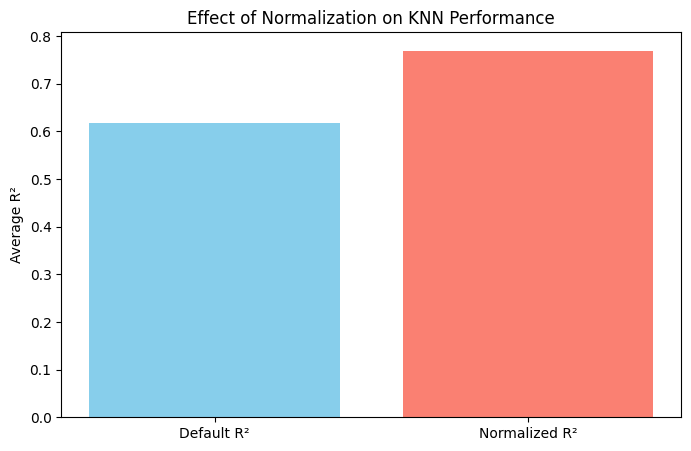

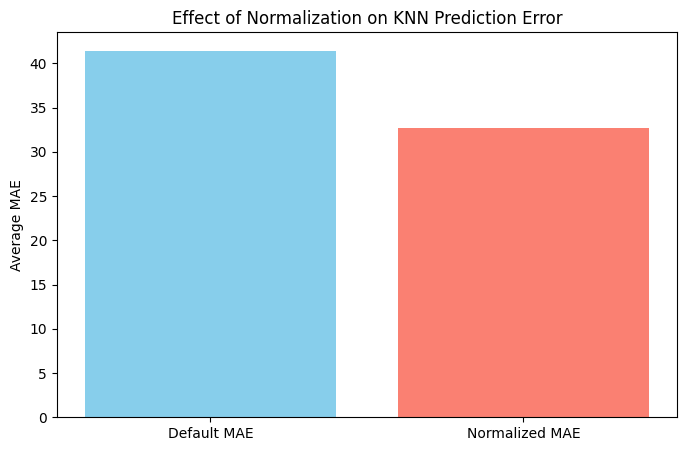

In [3]:
default_model = KNeighborsRegressor()
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

y_pred = cross_val_predict(default_model, X, Y, cv=kf)

#domain specific
y_pred = cross_val_predict(default_model, X, Y, cv=kf)
mae = mean_absolute_error(Y, y_pred)
#domain independent
r2_scores = cross_val_score(default_model, X, Y, cv=kf, scoring='r2')
average_r2 = r2_scores.mean()

print("Default model no preprocessing:")
print(f"MAE: {mae:.2f}")
print(f"R² for each fold: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {average_r2:.2f}")

#preprocessed
y_pred_scaled = cross_val_predict(default_model, X_scaled, Y, cv=kf)
mae_scaled = mean_absolute_error(Y, y_pred_scaled)
r2_scores_scaled = cross_val_score(default_model, X_scaled, Y, cv=kf, scoring='r2')
average_r2_scaled = r2_scores_scaled.mean()

print("\n Normalized model")
print(f"MAE: {mae_scaled:.3f}")
print(f"R² for each fold: {[round(score, 4) for score in r2_scores_scaled]}")
print(f"Average R²: {average_r2_scaled:.2f}")

plt.figure(figsize=(8,5))
plt.bar(["Default R²", "Normalized R²"], [average_r2, average_r2_scaled], color=['skyblue', 'salmon'])
plt.ylabel("Average R²")
plt.title("Effect of Normalization on KNN performance")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(["Default MAE", "Normalized MAE"], [mae,mae_scaled], color=['skyblue', 'salmon'])
plt.ylabel("Average MAE")
plt.title("Effect of Normalization on KNN Prediction Error")
plt.show()

For n_neighbors=1, weights=uniform Train R²=1.00, Test R²=0.72, MAE=34.82
For n_neighbors=1, weights=distance Train R²=1.00, Test R²=0.72, MAE=34.82
For n_neighbors=3, weights=uniform Train R²=0.89, Test R²=0.76, MAE=32.66
For n_neighbors=3, weights=distance Train R²=1.00, Test R²=0.79, MAE=30.59
For n_neighbors=5, weights=uniform Train R²=0.86, Test R²=0.77, MAE=32.68
For n_neighbors=5, weights=distance Train R²=1.00, Test R²=0.80, MAE=29.94
For n_neighbors=7, weights=uniform Train R²=0.83, Test R²=0.77, MAE=33.19
For n_neighbors=7, weights=distance Train R²=1.00, Test R²=0.80, MAE=30.22
For n_neighbors=9, weights=uniform Train R²=0.82, Test R²=0.75, MAE=34.16
For n_neighbors=9, weights=distance Train R²=1.00, Test R²=0.80, MAE=30.83
For n_neighbors=11, weights=uniform Train R²=0.80, Test R²=0.74, MAE=34.86
For n_neighbors=11, weights=distance Train R²=1.00, Test R²=0.79, MAE=31.41
For n_neighbors=13, weights=uniform Train R²=0.79, Test R²=0.74, MAE=35.26
For n_neighbors=13, weights=d

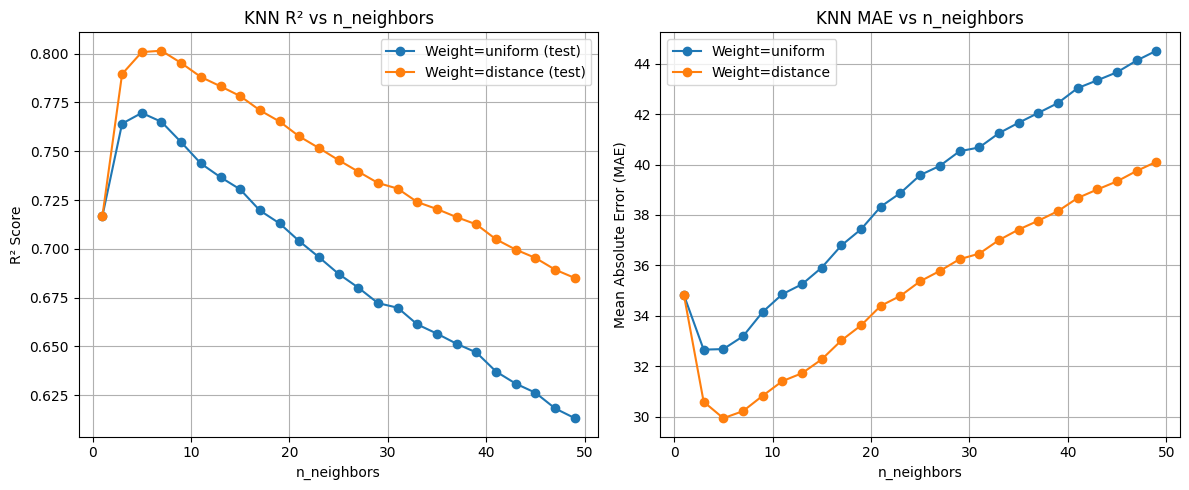

In [8]:
#hyperparameter values
n_neighbors_values = list(range(1, 51, 2))
weights_values = ['uniform', 'distance']

#store results for plotting
results_r2_knn = {(n, w): {"train": 0, "test": 0} for n in n_neighbors_values for w in weights_values}
results_mae_knn = {(n, w): 0 for n in n_neighbors_values for w in weights_values}

kf = KFold(n_splits=k, shuffle=True, random_state=42)

#parameters for gridsearch
param_grid = {'n_neighbors': n_neighbors_values,
              'weights': weights_values}

grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=kf,
    scoring='r2',
    return_train_score=True
)

grid_search.fit(X_scaled, Y)

#loop through all possible combinations 
cv_results = grid_search.cv_results_
for i in range(len(cv_results['params'])):
    n_neighbors = cv_results['params'][i]['n_neighbors']
    weights = cv_results['params'][i]['weights']
    mean_train_r2 = cv_results['mean_train_score'][i]
    mean_test_r2 = cv_results['mean_test_score'][i]
    
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    y_pred = cross_val_predict(model, X_scaled, Y, cv=kf)
    mae = mean_absolute_error(Y, y_pred)

    #store results
    results_r2_knn[(n_neighbors, weights)]["train"] = mean_train_r2
    results_r2_knn[(n_neighbors, weights)]["test"] = mean_test_r2
    results_mae_knn[(n_neighbors, weights)] = mae
    
    print(f"For n_neighbors={n_neighbors}, weights={weights} "f"Train R²={mean_train_r2:.2f}, Test R²={mean_test_r2:.2f}, MAE={mae:.2f}")

print("\nBest hyperparameters:", grid_search.best_params_)

plt.figure(figsize=(12,5))

#R² graph
plt.subplot(1,2,1)
for w in weights_values:
    test_vals = [results_r2_knn[(n, w)]["test"] for n in n_neighbors_values]
    plt.plot(n_neighbors_values, test_vals, marker='o', label=f"Weight={w} (test)")
plt.xlabel("n_neighbors")
plt.ylabel("R² Score")
plt.title("KNN R² vs n_neighbors")
plt.legend()
plt.grid(True)

#MAE graph
plt.subplot(1,2,2)
for w in weights_values:
    mae_vals = [results_mae_knn[(n, w)] for n in n_neighbors_values]
    plt.plot(n_neighbors_values, mae_vals, marker='o', label=f"Weight={w}")
plt.xlabel("n_neighbors")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("KNN MAE vs n_neighbors")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
